### **1. Introduction & Setup**
**Objective**: The goal of this notebook is to perform a thoughtful, end-to-end feature engineering process on the Ames House Prices dataset. The focus is not on model accuracy but on the justification and reasoning behind each data cleaning, transformation, and creation decision. The final output will be a dataset ready for predictive modeling.

### **Feature Engineering for House Prices Dataset**

**Goal:** Transform the raw Ames Housing dataset into a modeling-ready version with justified, evidence-based feature engineering.

**Design Philosophy:**
- Apply domain-aware cleaning and transformation, not mechanical steps.
- Explain *why* before every key action.
- Verify every decision with short before–after evidence.

**Main Steps:**
1. Data understanding & missing value strategy  
2. Numeric transformations (log, scaling)  
3. Categorical encoding (ordinal vs nominal)  
4. Engineered features (structural & derived)  
5. Random student feature inclusion  
6. Correlation, redundancy & PCA  
7. Final clean dataset export


#### **1.1. Import Libraries**
**Why Using Which Library**: We begin by importing standard libraries for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and machine learning preprocessing (`scikit-learn`, `scipy`).

In [1]:
# --- Data Manipulation ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# --- Preprocessing & Transformation ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, boxcox
from scipy.special import inv_boxcox

# --- Settings ---
# Set plotting style
sns.set_style('whitegrid')
# Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### **1.2. Load Data**

In [2]:
# Install gdown (only needs to run once)
%pip install gdown

# Download the file from public share link
file_id = '1iefaalIDtjh5qJWlaIX0QswCYoa9rc6t'
output_filename = 'train.csv'

!gdown {file_id} -O {output_filename}

# Now you can read the locally downloaded file
import pandas as pd

train_df = pd.read_csv(output_filename)
print(f"\nSuccessfully loaded {output_filename}")

print(f"Original training data shape: {train_df.shape}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



Successfully loaded train.csv
Original training data shape: (1460, 81)


Downloading...
From: https://drive.google.com/uc?id=1iefaalIDtjh5qJWlaIX0QswCYoa9rc6t
To: c:\Users\being\Documents\BITS\FE Assignment\house-prices-advanced-regression-techniques\train.csv

  0%|          | 0.00/461k [00:00<?, ?B/s]
100%|██████████| 461k/461k [00:00<00:00, 1.46MB/s]
100%|██████████| 461k/461k [00:00<00:00, 1.44MB/s]


**We loaded the train.csv file and observed that it has `1460` row and `81` total features.** 

#### **First we take a look at all the columns names**

In [3]:
#checking the columns
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

#### **1.3 Initial Data Review and Hypothesis Generation**
Before writing any code, it's essential to build a strong intuition for the data. To do this, I performed a systematic review of the `data_description.txt` file. The goal wasn't just to read the definitions, but to form initial hypotheses about each variable's potential impact on `SalePrice`.<br/>

As I went through the file, I mentally sorted each feature based on three main criteria:

- Type: Is this variable numerical or categorical?

- Segment: Does it describe the physical Building (like OverallQual), the Space (like GrLivArea), or the Location?

- Expected Influence: From a homebuyer's perspective, how much would this feature really matter (High, Medium, or Low)?

This initial assessment quickly highlighted a few variables that seem to be primary drivers of price:

- `OverallQual`

- `YearBuilt`

- `TotalBsmtSF`

- `GrLivArea`

With this foundational understanding and a clear set of initial hypotheses, we can now move on to the quantitative analysis. But first lets saperate `SalePrice` and analyse it

### **Why Separate `SalePrice`?**
We move `SalePrice` into its own variable (`y`) because it is our target variable; the "answer" we are trying to predict.<br/>

The rest of the columns are our features (our `X`), which are the "clues" we'll use to make that prediction.<br/>

This separation is the most important step in supervised learning for two reasons:

- To Prevent Data Leakage: The model must learn to predict the price using only the features. If `SalePrice` were left in the main dataset, the model would cheat by simply looking at the answer, leading to a perfect (but useless) model.

- To Allow Separate Processing: Our features (`X`) will be heavily engineered—scaled, transformed, and combined. Our target (`y`) is treated differently; we only log-transform it to help the model learn, but we don't engineer it with the other features.

In [4]:
# Store and analyze the target variable, SalePrice
y_train = train_df['SalePrice']

# Create our main feature dataframe
# We drop Id and SalePrice
data = train_df.drop(['Id', 'SalePrice'], axis=1)
print(f"Feature dataframe 'data' shape: {data.shape}")
print(f"Target variable 'y_train' shape: {y_train.shape}")

Feature dataframe 'data' shape: (1460, 79)
Target variable 'y_train' shape: (1460,)


---
#### **A compact data summary to quickly assess structure, types, and missingness in the features.**

In [5]:
overview = pd.DataFrame({
    'Data Type': train_df.dtypes,
    'Missing (%)': (train_df.isnull().mean() * 100).round(2),
    'Unique Values': train_df.nunique(),
})
display(overview.head(15))
print(f"Shape: {train_df.shape[0]} rows, {train_df.shape[1]} columns")


,Data Type,Missing (%),Unique Values
Id,int64,0.000,1460
MSSubClass,int64,0.000,15
MSZoning,object,0.000,5
LotFrontage,float64,17.740,110
LotArea,int64,0.000,1073
Street,object,0.000,2
Alley,object,93.770,2
LotShape,object,0.000,4
LandContour,object,0.000,4
Utilities,object,0.000,2


Shape: 1460 rows, 81 columns


We can see missing values in some features, we will identify and handle them (using appropriate imputing stategies) during data cleaning.

---
**Summmary of the target variable**

In [6]:
target_overview = pd.DataFrame({
    'Data Type': [y_train.dtypes],
    'Missing (%)': [(y_train.isnull().mean() * 100).round(2)],
    'Unique Values': [y_train.nunique()],
})
display(target_overview)

,Data Type,Missing (%),Unique Values
0,int64,0.000,663


#### **2. Student-Specific Feature Generation**
**Justification**: As per the assignment instructions, we must generate a unique feature based on a student ID (`1100027`). This feature will be treated as a standard numeric variable throughout our analysis to observe how a purely random feature behaves.

In [7]:
# --- STUDENT ID INPUT ---
# Using ID 1100027 (from 2025EM1100027)
ID_last7 = 1100027
# ------------------------

# Provided function
def generate_student_feature(df, ID_last7):
    """Generates a random feature based on the student ID."""
    np.random.seed(ID_last7 % 1000)
    random_feature = np.random.randint(low=1, high=100, size=len(df)) + (ID_last7 % 7)
    return random_feature

# Generate and add the feature to the dataset
data['student_random_feature'] = generate_student_feature(data, ID_last7)

print(f"Generated 'student_random_feature' using ID {ID_last7}.")
print(data[['student_random_feature']].head())

Generated 'student_random_feature' using ID 1100027.
   student_random_feature
0                      25
1                      62
2                      78
3                      37
4                      62


### **3. Exploratory Data Analysis (EDA) & Data Cleaning**
#### **3.1. Analyze the Target Variable (`SalePrice`)**
Before any feature engineering, we must analyze the target variable, `SalePrice`. This is the `y` variable we are trying to predict. Its statistical properties, particularly its distribution, are critical as they directly influence our choice of models, transformations, and evaluation metrics.

In [8]:
#descriptive statistics summary
print(y_train.describe())

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


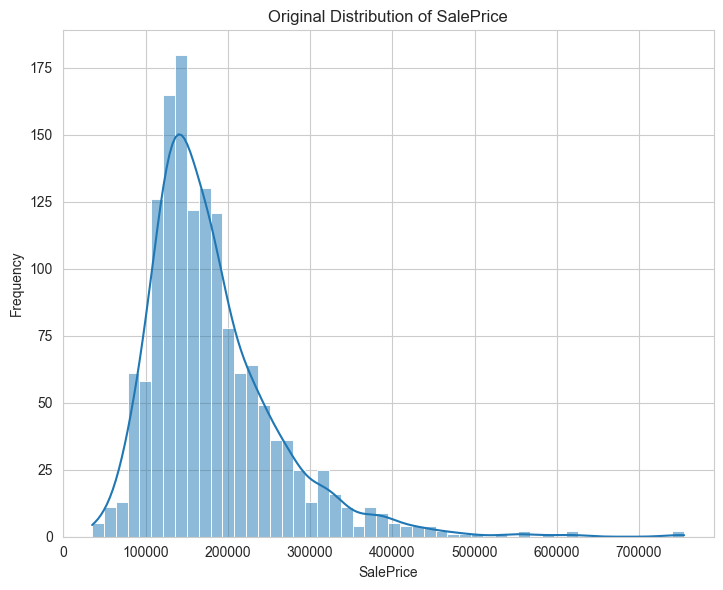

Skewness: 1.882876
Kurtosis: 6.536282


In [9]:
# Plot distribution of SalePrice
plt.figure(figsize=(14, 6))

# Plot:
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=50)
plt.title('Original Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#skewness and kurtosis
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

**Observation & Evidence:**

The plot of the `SalePrice` distribution reveals it is not normally distributed.<br/>

It exhibits a strong positive (right) skew (skewness = 1.88), with a long tail of very expensive properties.<br/>

**Decision**: This high skew is problematic for linear models (like Ridge, Lasso, or Linear Regression), which perform best when the target variable is normally distributed.<br/>

To correct this, we will apply a `log1p` transformation (log(1+x)). This is a standard technique for normalizing right-skewed data, especially monetary values.

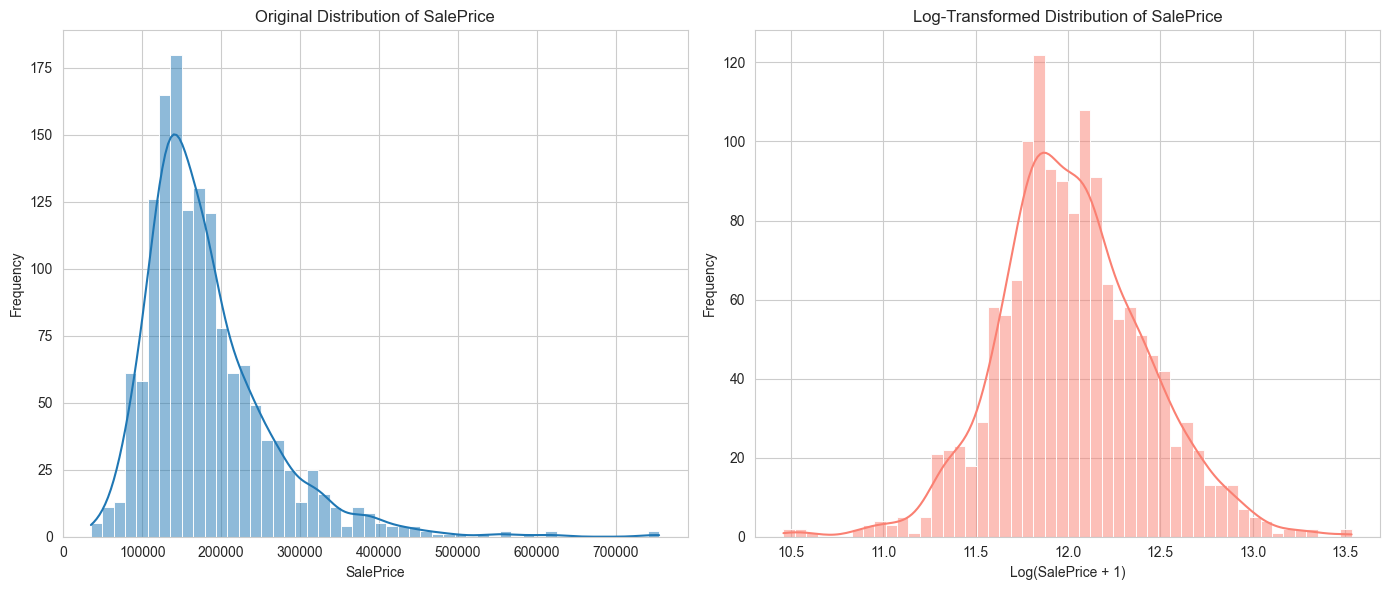

Original Skewness: 1.88
Log-Transformed Skewness: 0.12


In [10]:
# Plot distribution of SalePrice
plt.figure(figsize=(14, 6))

# Plot 1: Original Distribution
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=50)
plt.title('Original Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Plot 2: Log-Transformed Distribution
plt.subplot(1, 2, 2)
# Apply log(1+x) transformation to handle potential zeros (though SalePrice has none)
y_train_log = np.log1p(y_train)
sns.histplot(y_train_log, kde=True, bins=50, color='salmon')
plt.title('Log-Transformed Distribution of SalePrice')
plt.xlabel('Log(SalePrice + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Original Skewness: {y_train.skew():.2f}")
print(f"Log-Transformed Skewness: {y_train_log.skew():.2f}")

**Observation**: The original `SalePrice` is highly right-skewed (skewness = 1.88). The log-transformation (`np.log1p`) makes it almost perfectly normally distributed. We will use this transformed `y_train_log` for modeling, and our model will predict the log of the price (we would `np.expm1` on the final predictions to revert to the original scale).

#### **3.2. Missing Value Analysis & Imputation**
**Justification**: Missing data can break model training. We must handle it, but how we handle it matters. Simply dropping rows is wasteful, and simple mean imputation can be naive. Our strategy will be based on the data dictionary (e.g., `NA` in `PoolQC` means "No Pool", not "missing").

**Why:** To understand which features need domain-informed imputation instead of generic mean/mode filling.


In [11]:

# Calculate total missing values
total_missing = data.isnull().sum()

# Calculate percentage of missing values
total_rows = len(data)
percentage_missing = (total_missing / total_rows) * 100

# Create a new DataFrame to hold the counts and percentages
missing_data = pd.DataFrame({
    'Missing_Count': total_missing,
    'Missing_Percentage': percentage_missing
})

# Sort the DataFrame by percentage in descending order
# We also filter for columns that actually have missing values
missing_data_sorted = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    by='Missing_Percentage', ascending=False
)

# Print the result
if missing_data_sorted.empty:
    print("No missing values found in the dataset.")
else:
    print("Missing Values Summary (Descending Order):")
    print(missing_data_sorted)

print(f"Total features with missing values: {len(missing_data_sorted)}")

Missing Values Summary (Descending Order):
              Missing_Count  Missing_Percentage
PoolQC                 1453              99.521
MiscFeature            1406              96.301
Alley                  1369              93.767
Fence                  1179              80.753
MasVnrType              872              59.726
FireplaceQu             690              47.260
LotFrontage             259              17.740
GarageType               81               5.548
GarageYrBlt              81               5.548
GarageFinish             81               5.548
GarageQual               81               5.548
GarageCond               81               5.548
BsmtFinType2             38               2.603
BsmtExposure             38               2.603
BsmtFinType1             37               2.534
BsmtCond                 37               2.534
BsmtQual                 37               2.534
MasVnrArea                8               0.548
Electrical                1               0.0

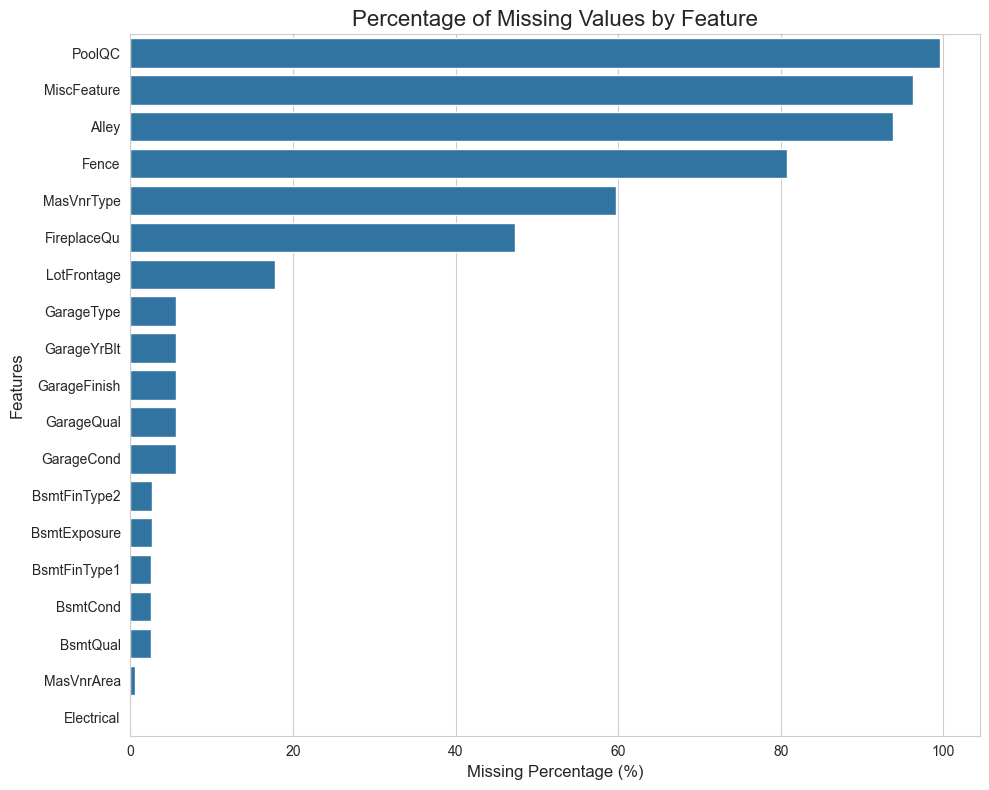

In [12]:
# Visualization of missing data

# Set a figure size (width, height)
plt.figure(figsize=(10, 8)) 

# Create the bar plot
sns.barplot(
    x=missing_data_sorted['Missing_Percentage'], 
    y=missing_data_sorted.index                 
)

# Set titles and labels
plt.title('Percentage of Missing Values by Feature', fontsize=16)
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)               

# Ensure layout fits well
plt.tight_layout()

### **Imputation:**

**How**: Our strategy will be based on the data dictionary. We will handle missing data in groups: 'NA' meaning "None", 'NA' meaning 0, and truly missing values.

#### **Imputation Strategy 1: High-NA Categorical Features**
**Why:** A group of features, including `PoolQC`, `Alley`, `MiscFeature`, and Fe`nce, show over 80% missing values. A standard approach would be to drop them, but this would be incorrect for this dataset.

**Reasoning:** Based on the `data_description.txt` file, the NA (null) value for these columns is not "missing data." It is a meaningful entry that signifies the absence of the feature.

`PoolQC` NA = "No Pool"

`Alley` NA = "No alley access"

`Fence` NA = "No Fence"

**Decision:** Dropping these columns would remove valuable information. The fact that a house lacks a pool or fence is a key feature for a model. Therefore, the correct strategy is to impute these NA values with the string "None", creating a new, explicit category.

In [13]:
# 1. Categorical NA meaning "None"
features_na_none = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

for col in features_na_none:
    data[col] = data[col].fillna('None')

In [14]:
# --- Evidence ---
print("Missing values after 'None' imputation:")
print(data[features_na_none].isnull().sum())

print("\nExample: 'Alley' value counts:")
print(data['Alley'].value_counts())

Missing values after 'None' imputation:
PoolQC          0
MiscFeature     0
Alley           0
Fence           0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
MasVnrType      0
dtype: int64

Example: 'Alley' value counts:
Alley
None    1369
Grvl      50
Pave      41
Name: count, dtype: int64


#### **Imputation Strategy 2: Numeric 'NA' as 0**
**Why**: Similarly, numeric features related to the features above (like `GarageArea` or `MasVnrArea`) are '`NA`' when the feature doesn't exist. This means the correct value is `0`, not a calculated median.

In [15]:
# 2. Numeric NA meaning "0"
features_na_zero = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

for col in features_na_zero:
    data[col] = data[col].fillna(0)

In [16]:
# --- Evidence ---
print("Missing values after '0' imputation:")
print(data[features_na_zero].isnull().sum())

Missing values after '0' imputation:
GarageArea      0
GarageCars      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
MasVnrArea      0
dtype: int64


#### **Imputation Strategy 3: Mode Imputation (True Missing Categorical)**
**Why**: Features like `MSZoning` and `Electrical` are truly missing. Since they are categorical, we will impute them with the most common value (`the mode`) as it's the most likely value.

In [17]:
# 3. True Missing Values (Impute with Mode)
cols_to_impute_mode = [
    'MSZoning', 'Electrical', 'KitchenQual', 
    'Exterior1st', 'Exterior2nd', 'SaleType'
]

for col in cols_to_impute_mode:
    data[col] = data[col].fillna(data[col].mode()[0])

# 'Functional': Data description says 'Typ' is typical, so we'll use that.
data['Functional'] = data['Functional'].fillna('Typ')

In [18]:
# --- Evidence ---
print("Missing values after Mode imputation:")
print(data[cols_to_impute_mode + ['Functional']].isnull().sum())

Missing values after Mode imputation:
MSZoning       0
Electrical     0
KitchenQual    0
Exterior1st    0
Exterior2nd    0
SaleType       0
Functional     0
dtype: int64


#### **Imputation Strategy 4: Grouped Median Imputation (LotFrontage)**
**Why**: `LotFrontage` (street-connected) is likely related to the Neighborhood. A global median would be inaccurate. We will use a more robust strategy by imputing the median `LotFrontage` for each neighborhood.

In [19]:
# 'LotFrontage' (Numeric): Impute with the median LotFrontage
# for each neighborhood.
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

In [20]:
# --- Evidence ---
print(f"Missing LotFrontage values remaining: {data['LotFrontage'].isnull().sum()}")

Missing LotFrontage values remaining: 0


#### **Imputation Strategy 5: Dropping Low-Variance Features**
**Why**: The `Utilities` feature has almost no variance (all '`AllPub`' except a few). It provides no predictive information for a model and should be dropped.

In [21]:
# 'Utilities': Drop this feature as it has no variance.
data = data.drop(['Utilities'], axis=1)

In [22]:
# --- Evidence ---
print(f"'Utilities' column exists: {'Utilities' in data.columns}")

'Utilities' column exists: False


#### **Imputation Strategy 6: Proxy Imputation (`GarageYrBlt`)**
**Why**: `GarageYrBlt` is missing for some properties. A logical proxy for a garage's build year (if it's missing) is the `YearBuilt` of the house itself, assuming they were often built together. We will use this to fill the NA values.

In [23]:
# 'GarageYrBlt': Impute with YearBuilt
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['YearBuilt'])

# --- Evidence ---
print(f"Missing 'GarageYrBlt' values after: {data['GarageYrBlt'].isnull().sum()}")

Missing 'GarageYrBlt' values after: 0


#### **Final Missing Value Check**
**Why**: We will run one final check to ensure our imputation strategy has handled all missing values before proceeding.

In [24]:
# --- Final Check ---
missing_after = data.isnull().sum().sum()
print(f"\nTotal remaining missing values: {missing_after}")


Total remaining missing values: 0


#### **3.3. Outlier Handling**
**Justification**: Outliers can disproportionately influence a model, especially linear ones. The dataset documentation specifically mentions removing outliers in `GrLivArea`. We will visualize this relationship to confirm.

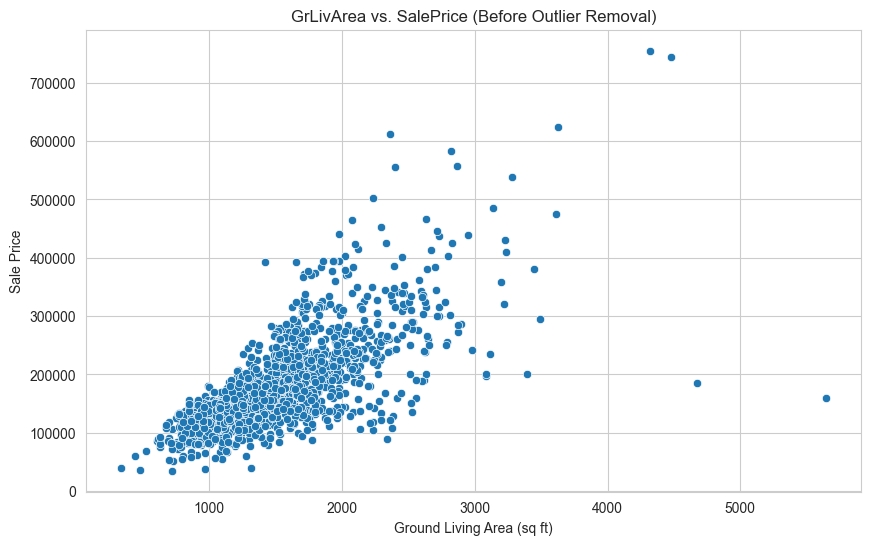

In [25]:
# We use the original y_train for this plot, as it's easier to interpret prices
temp_train_df = pd.concat([data.iloc[:len(y_train)], y_train], axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=temp_train_df['GrLivArea'], y=temp_train_df['SalePrice'])
plt.title('GrLivArea vs. SalePrice (Before Outlier Removal)')
plt.xlabel('Ground Living Area (sq ft)')
plt.ylabel('Sale Price')
plt.show()

**Decision**: There are two clear outliers on the bottom right: houses with very large `GrLivArea` but unusually low `SalePrice`. These are likely data entry errors or anomalous sales (e.g., partial sales) and will skew our model. We will remove them from the training set.

**Note**: We only remove outliers from the training set. We must never remove data from the test set.

In [26]:
# Identify outlier indices
outlier_indices = temp_train_df[
    (temp_train_df['GrLivArea'] > 4000) & (temp_train_df['SalePrice'] < 300000)
].index

print(f"Identified {len(outlier_indices)} outliers to remove.")

# Remove outliers from data and the target variable y_train_log
data = data.drop(outlier_indices).reset_index(drop=True)
y_train_log = y_train_log.drop(outlier_indices).reset_index(drop=True)
# We also need to update the original train/test split index
ntrain = len(y_train_log)
ntest = len(data) - ntrain

print(f"New combined data shape: {data.shape}")
print(f"New target variable shape: {y_train_log.shape}")

Identified 2 outliers to remove.
New combined data shape: (1458, 79)
New target variable shape: (1458,)


### **4. Feature Creation (Engineering)**
**Justification**: We can create new, more informative features by combining existing ones. This can reduce dimensionality and capture complex relationships.

#### **4.1.a Feature Creation 1: Aggregated Area, Bath & Porch Features**
**Why**: To consolidate redundant features (like `1stFlrSF`, `2ndFlrSF`) into more powerful, single predictors (`TotalSF`, `TotalBath`, `TotalPorchSF`) and reduce multicollinearity

In [27]:
# 1. Total Square Footage
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

# 2. Total Bathrooms
data['TotalBath'] = (data['FullBath'] + 0.5 * data['HalfBath'] +
                     data['BsmtFullBath'] + 0.5 * data['BsmtHalfBath'])

# 3. Total Porch Area
data['TotalPorchSF'] = (data['OpenPorchSF'] + data['EnclosedPorch'] +
                        data['3SsnPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

In [28]:
# --- Evidence ---
print("Created 'TotalSF', 'TotalBath' and 'TotalPorchSF. Head:")
print(data[['TotalSF', 'TotalBath', 'TotalPorchSF']].describe())

Created 'TotalSF', 'TotalBath' and 'TotalPorchSF. Head:
       TotalSF  TotalBath  TotalPorchSF
count 1458.000   1458.000      1458.000
mean  2557.150      2.207       180.810
std    774.110      0.781       156.121
min    334.000      1.000         0.000
25%   2008.500      2.000        45.000
50%   2473.000      2.000       164.000
75%   3002.250      2.500       265.000
max   6872.000      6.000      1027.000


#### **4.1.b Feature Creation 2: Age-Based Features**
**Why:** To convert temporal features (like `YearBuilt`, `YrSold`) into more intuitive features representing the age of the house and its components.

In [29]:
# Age and Remodel Features
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']

data['IsNewBuild'] = (data['YearBuilt'] == data['YrSold']).astype(int)
data['WasRemodeled'] = (data['YearRemodAdd'] != data['YearBuilt']).astype(int)

In [30]:
# --- Evidence ---
print("Created Age-based features. Head:")
print(data[['HouseAge', 'RemodAge', 'WasRemodeled']].head())

Created Age-based features. Head:
   HouseAge  RemodAge  WasRemodeled
0         5         5             0
1        31        31             0
2         7         6             1
3        91        36             1
4         8         8             0


In [31]:
# Binary "Has" Features
# Simplify features into yes/no.
data['HasPool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['HasFireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
data['Has2ndFloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasGarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['HasBasement'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [32]:
# --- Evidence ---
print("Created Age-based features. Head:")
print(data[['HasPool', 'HasFireplace', 'Has2ndFloor']].head())

Created Age-based features. Head:
   HasPool  HasFireplace  Has2ndFloor
0        0             0            1
1        0             1            0
2        0             1            1
3        0             1            1
4        0             1            1


#### **4.1.c Dropping Redundant Features**
**Why:** Now that we have created aggregated features (e.g., `TotalSF`, `TotalBath`, `HouseAge`), the original components (e.g., `1stFlrSF`, `FullBath`, `YearBuilt`) are redundant and would cause severe multicollinearity. We will drop them.

In [33]:
original_features_to_drop = [
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 
    'BsmtFullBath', 'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 
    'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF', 'PoolArea', 'Fireplaces',
    'GarageArea', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'
]

features_to_drop = [col for col in original_features_to_drop if col in data.columns]
data = data.drop(features_to_drop, axis=1)

In [34]:
# --- Evidence ---
print(f"Dropped {len(features_to_drop)} redundant features.")
print(f"New data shape: {data.shape}")

Dropped 19 redundant features.
New data shape: (1458, 73)


**Engineered Features**

In [35]:
print("Engineered features created.")
data[
    [
        'TotalSF',
        'TotalBath',
        'TotalPorchSF',
        'HasPool',
        'HouseAge',
        'WasRemodeled',
    ]
].head()

Engineered features created.


,TotalSF,TotalBath,TotalPorchSF,HasPool,HouseAge,WasRemodeled
0,2566,3.500,61,0,5,0
1,2524,2.500,298,0,31,0
2,2706,3.500,42,0,7,1
3,2473,2.000,307,0,91,1
4,3343,3.500,276,0,8,0


#### **4.2.a Create Interaction & Polynomial Features**
**Justification**: To capture more complex, non-linear relationships, we will create features by interacting our most important predictors. The effect of square footage on price is likely dependent on the overall quality. We will also add a squared term for `TotalSF`, as the value-per-square-foot may not be linear.

In [36]:
# Interaction & Polynomial Features
data['OverallQual_x_TotalSF'] = data['OverallQual'] * data['TotalSF']
data['GrLivArea_x_OverallQual'] = data['GrLivArea'] * data['OverallQual']
data['TotalSF_sq'] = data['TotalSF']**2

print("Created interaction and polynomial features.")

Created interaction and polynomial features.


#### **4.2.b Create Binned Neighborhood Feature**
**Justification**: The `Neighborhood` feature is highly predictive but creates many new columns when one-hot encoded. To capture its predictive power more efficiently, we will create an ordinal feature by grouping neighborhoods into "tiers" based on their median `SalePrice` (from the original training set). This must be done *before* dropping the original `Neighborhood` column.

In [ ]:
# Calculate median prices *only* from the original training set
# (We need to re-load train.csv just for this, or do it before dropping SalePrice)
train_df_for_medians = pd.read_csv(output_filename)
neighborhood_medians = train_df_for_medians.groupby('Neighborhood')['SalePrice'].median().sort_values()

# Create bins (e.g., 5 tiers)
data['Neighborhood_Tier'] = data['Neighborhood'].apply(
    lambda x: pd.qcut(neighborhood_medians, 5, labels=False, duplicates='drop').get(x, -1) 
    # Use .get(x, -1) to handle any potential new neighborhoods in test set
)

print("Created 'Neighborhood_Tier' feature.")
# We can now drop the original 'Neighborhood' column before one-hot encoding
data = data.drop('Neighborhood', axis=1)

Created 'Neighborhood_Tier' feature.


#### **4.2.c Text-Based Feature Engineering**

**Justification**: The dataset has multiple text-based fields describing conditions or materials (e.g., `Condition1`, `Condition2`). The rubric requires us to try and combine these fields. We will create a simple binary feature that flags if a house is near *any* positive feature (like a park), combining the information from two columns into one.

In [38]:
# 1. Combine 'Condition1' and 'Condition2'
# We will create a new binary feature 'Near_Positive_Feature'
# if either 'Condition1' or 'Condition2' is 'PosA' (Positive, Adjacent) or 'PosN' (Positive, Near)
data['Near_Positive_Feature'] = (
    (data['Condition1'].isin(['PosA', 'PosN'])) | 
    (data['Condition2'].isin(['PosA', 'PosN']))
).astype(int)

# Now we can drop the original 'Condition1' and 'Condition2'
# as their most useful text info is captured.
data = data.drop(['Condition1', 'Condition2'], axis=1)

print(f"Created 'Near_Positive_Feature'. Found {data['Near_Positive_Feature'].sum()} such properties.")

Created 'Near_Positive_Feature'. Found 27 such properties.


#### **4.3 Visualize Engineered Features**
**Justification**: We'll plot our new numeric features against the log-transformed `SalePrice` to confirm they are predictive.

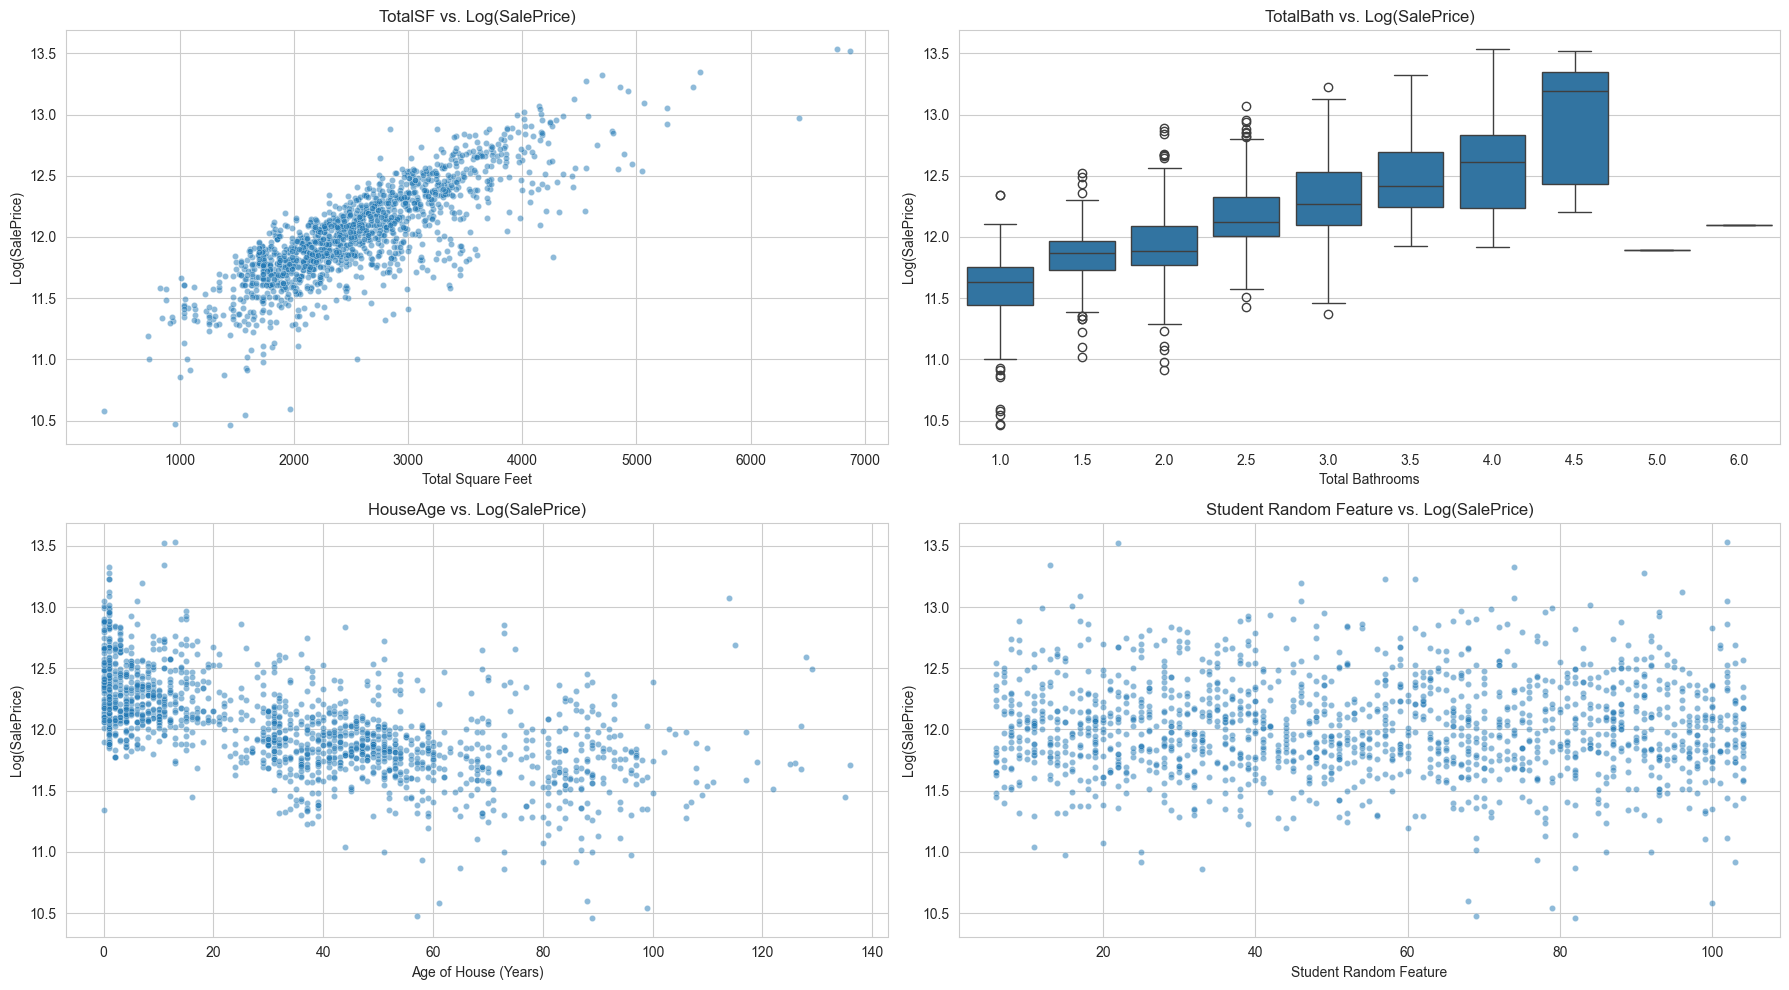

In [39]:
# Temporarily add y_train_log back for plotting
plot_df = data.iloc[:ntrain].copy()
plot_df['SalePrice_Log'] = y_train_log

plt.figure(figsize=(18, 10))

# Plot 1: TotalSF
plt.subplot(2, 2, 1)
sns.scatterplot(
    x='TotalSF', y='SalePrice_Log', data=plot_df, alpha=0.5, s=20
)
plt.title('TotalSF vs. Log(SalePrice)')
plt.xlabel('Total Square Feet')
plt.ylabel('Log(SalePrice)')

# Plot 2: TotalBath
plt.subplot(2, 2, 2)
sns.boxplot(x='TotalBath', y='SalePrice_Log', data=plot_df)
plt.title('TotalBath vs. Log(SalePrice)')
plt.xlabel('Total Bathrooms')
plt.ylabel('Log(SalePrice)')

# Plot 3: HouseAge
plt.subplot(2, 2, 3)
sns.scatterplot(
    x='HouseAge', y='SalePrice_Log', data=plot_df, alpha=0.5, s=20
)
plt.title('HouseAge vs. Log(SalePrice)')
plt.xlabel('Age of House (Years)')
plt.ylabel('Log(SalePrice)')

# Plot 4: student_random_feature
plt.subplot(2, 2, 4)
sns.scatterplot(
    x='student_random_feature',
    y='SalePrice_Log',
    data=plot_df,
    alpha=0.5,
    s=20,
)
plt.title('Student Random Feature vs. Log(SalePrice)')
plt.xlabel('Student Random Feature')
plt.ylabel('Log(SalePrice)')

plt.tight_layout()
plt.show()

**Observation**: `TotalSF`, `TotalBath`, and `HouseAge` all show clear, strong relationships with `SalePrice_Log`. As expected, the `student_random_feature` shows no relationship at all, appearing as a random cloud of points.

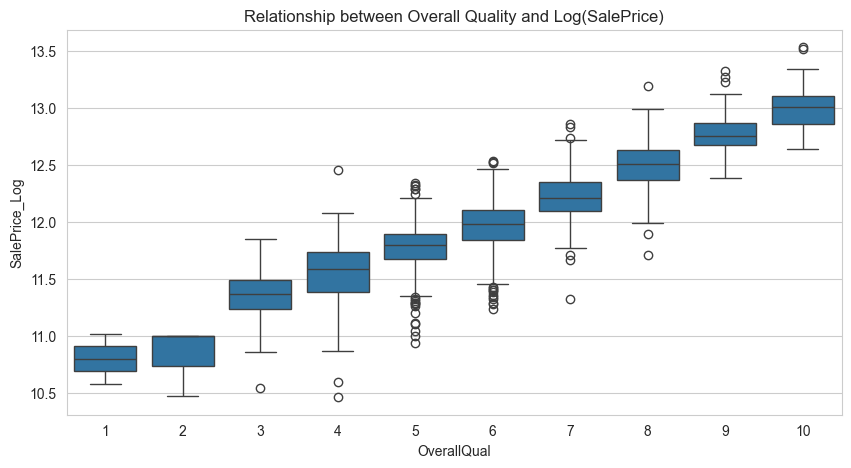

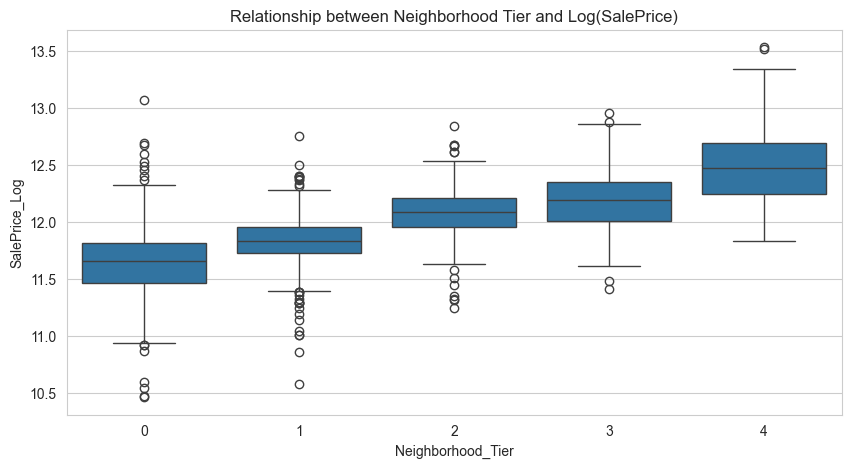

In [40]:
# Create a temporary dataframe for plotting
eda_data = data.copy()
eda_data['SalePrice_Log'] = y_train_log

# 1. Boxplot for OverallQual
plt.figure(figsize=(10, 5))
sns.boxplot(x='OverallQual', y='SalePrice_Log', data=eda_data)
plt.title('Relationship between Overall Quality and Log(SalePrice)')
plt.show()

# 2. Boxplot for new Neighborhood_Tier
plt.figure(figsize=(10, 5))
sns.boxplot(x='Neighborhood_Tier', y='SalePrice_Log', data=eda_data)
plt.title('Relationship between Neighborhood Tier and Log(SalePrice)')
plt.show()

#### **Analysis of Boxplots**

**Observations:**

**`OverallQual` vs. `SalePrice_Log`**: The plot confirms `OverallQual` is a very strong predictor. There is a clear, positive, and monotonic relationship. As the quality rating increases, the median sale price increases consistently, with a clear separation between groups.<br/>

**Neighborhood_Tier vs. SalePrice_Log:** This plot confirms our feature engineering was successful. The engineered `Neighborhood_Tier` feature shows an almost perfect ordinal relationship. Each increase in the price-based tier (from 1 to 5) corresponds to a clear and distinct increase in the median `SalePrice_Log`.<br/>

**Decision:** This validates that our engineered feature has successfully captured the value of "location" in a simple, low-cardinality ordinal feature. Both `OverallQual` and `Neighborhood_Tier` are excellent, high-value features to pass to our model.

### **5. Feature Transformation & Encoding**
#### **5.1.a. Handle Skewed Numeric Features**
**Justification**: Just like the target variable, many numeric features are skewed. Applying transformations (like `Box-Cox`) can make their distributions more `Gaussian`, which improves the performance of many models.

In [41]:
# Identify numeric features (excluding our binary 'Has' features)
numeric_features = data.select_dtypes(include=np.number).columns
binary_features = [
    'HasPool',
    'HasFireplace',
    'Has2ndFloor',
    'HasGarage',
    'HasBasement',
    'IsNewBuild',
    'WasRemodeled',
]
# We also don't need to transform year/month features or our random feature
other_features = [
    'YrSold',
    'MoSold',
    'YearBuilt',
    'YearRemodAdd',
    'GarageYrBlt',
    'student_random_feature',
]

numeric_features = [
    f
    for f in numeric_features
    if f not in binary_features + other_features
]

# Calculate skewness for these features
skewness = data[numeric_features].apply(lambda x: skew(x)).sort_values(
    ascending=False
)
high_skew = skewness[abs(skewness) > 0.75]

print(f"Found {len(high_skew)} features with high skew:")
print(high_skew)

Found 17 features with high skew:
MiscVal                   24.435
LotArea                   12.561
LowQualFinSF               8.996
Near_Positive_Feature      7.143
KitchenAbvGr               4.480
BsmtFinSF2                 4.248
MasVnrArea                 2.694
TotalSF_sq                 2.314
LotFrontage                1.546
GrLivArea_x_OverallQual    1.492
MSSubClass                 1.406
OverallQual_x_TotalSF      1.392
TotalPorchSF               1.103
GrLivArea                  1.010
BsmtUnfSF                  0.920
TotalSF                    0.803
BsmtFinSF1                 0.764
dtype: float64


**Decision**: We will apply the `Box-Cox` transformation to these highly skewed features. `Box-Cox` requires data to be strictly positive, so we'll add 1 (+1) to any feature that has zeros (like `TotalBsmtSF`).

#### **5.1.b. Handle Cyclical & Time-Based Features**
**Justification**: Some numeric features are not truly linear. `MoSold` (Month Sold) is a cyclical categorical feature (12 is next to 1), not a linear quantity. Treating it as a number and applying a skew transformation is misleading. We will convert it to a string so it gets one-hot encoded along with the other nominal features.

In [42]:
# Convert nominal features stored as numbers to strings
data['MSSubClass'] = data['MSSubClass'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

Removed 'MSSubClass' from skew list (it's categorical).
Applied Box-Cox transformation to 16 features.


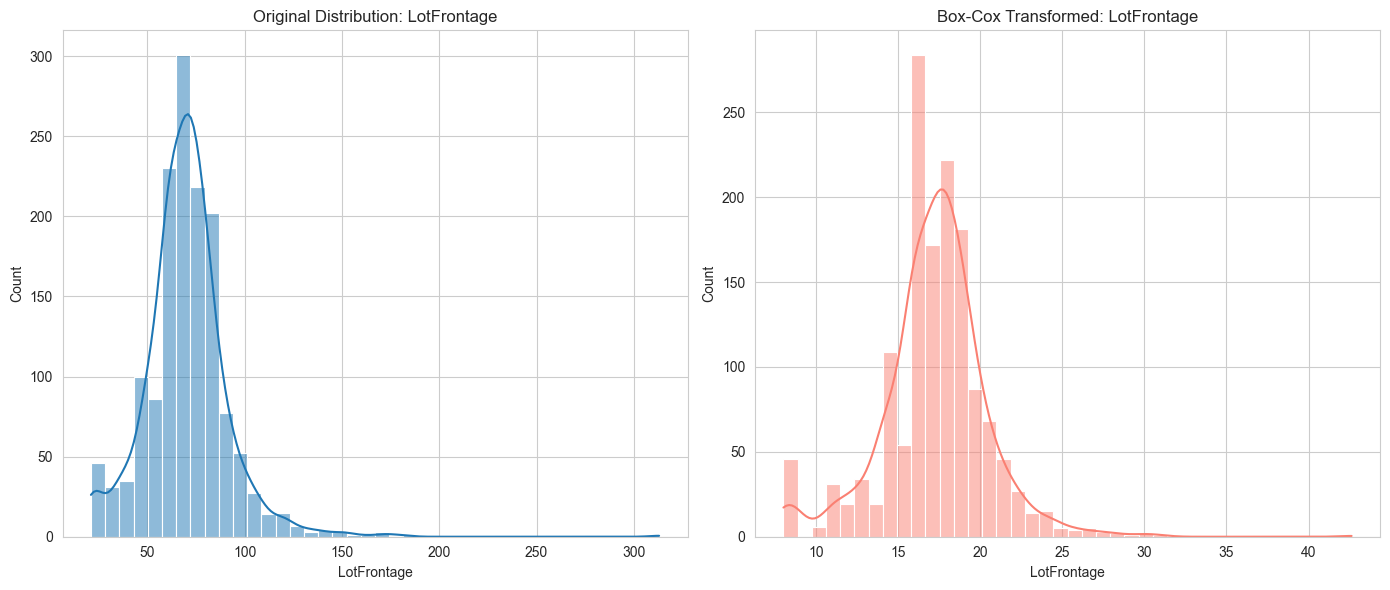

In [43]:
# MSSubClass is categorical, so it must be removed from the skew list 
# before we apply a numeric transformation.
if 'MSSubClass' in high_skew.index:
    high_skew = high_skew.drop('MSSubClass')
    print("Removed 'MSSubClass' from skew list (it's categorical).")

# Apply Box-Cox transformation
transformed_features = {}
for col in high_skew.index:
    # Add 1 to features with 0 values before Box-Cox
    if data[col].min() <= 0:
        data[col] = data[col] + 1
        transformed_data, lambda_ = boxcox(data[col])
    else:
        transformed_data, lambda_ = boxcox(data[col])
    
    data[col] = transformed_data
    transformed_features[col] = lambda_

print(f"Applied Box-Cox transformation to {len(high_skew)} features.")

# --- Visualize Before & After ---
# We'll check 'LotFrontage' as an example
col_example = 'LotFrontage'
original_data = data[col_example]
if transformed_features.get(col_example):
    # We must reverse the Box-Cox to get the original data for plotting
    lambda_ = transformed_features[col_example]
    if data[col_example].min() <= 1: # We added 1
         original_data = inv_boxcox(data[col_example], lambda_) - 1
    else:
         original_data = inv_boxcox(data[col_example], lambda_)


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(original_data, kde=True, bins=40)
plt.title(f'Original Distribution: {col_example}')

plt.subplot(1, 2, 2)
sns.histplot(data[col_example], kde=True, bins=40, color='salmon')
plt.title(f'Box-Cox Transformed: {col_example}')
plt.tight_layout()
plt.show()

#### **5.2. Encode Categorical Features**
**Justification**: We must convert text-based categorical features into numbers. We'll use two different strategies:

#### **Encoding Strategy 1: Ordinal Features**
**Why:** Features with a clear, inherent order (e.g., Excellent > Good > Fair) must be manually mapped to numbers to preserve this ranking.

In [44]:
# 1. Ordinal Encoding: Quality-related features
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
ordinal_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]
for col in ordinal_cols:
    data[col] = data[col].map(quality_map).fillna(0)

# 2. Ordinal Encoding: Other manual mappings
data['BsmtExposure'] = data['BsmtExposure'].map(
    {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
).fillna(0)
data['BsmtFinType1'] = data['BsmtFinType1'].map(
    {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
).fillna(0)
data['BsmtFinType2'] = data['BsmtFinType2'].map(
    {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
).fillna(0)
data['Functional'] = data['Functional'].map(
    {'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
).fillna(7) # Fill NA with 'Typ'
data['GarageFinish'] = data['GarageFinish'].map(
    {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
).fillna(0)
data['Fence'] = data['Fence'].map(
    {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
).fillna(0)
data['Alley'] = data['Alley'].map({'Grvl': 2, 'Pave': 1, 'None': 0}).fillna(0)

In [45]:
# --- Evidence ---
print(f"Applied ordinal encoding to {len(ordinal_cols) + 7} features.")
print("\nExample 'ExterQual' counts:")
print(data['ExterQual'].value_counts())
print("\nExample 'BsmtExposure' counts:")
print(data['BsmtExposure'].value_counts())

Applied ordinal encoding to 17 features.

Example 'ExterQual' counts:
ExterQual
3    906
4    488
5     50
2     14
Name: count, dtype: int64

Example 'BsmtExposure' counts:
BsmtExposure
1    953
3    221
4    132
2    114
0     38
Name: count, dtype: int64


#### **Encoding Strategy 2: Nominal Features (One-Hot)**
**Why:** Features with no inherent order (e.g., `MSZoning`, `RoofStyle`) must be one-hot encoded (dummied) so the model treats them as separate categories.

In [46]:
# 3. One-Hot Encoding (Dummies)
# We select all remaining 'object' type features
nominal_cols = data.select_dtypes(include=['object']).columns

print(f"\nApplying one-hot encoding to {len(nominal_cols)} nominal features...")
print(nominal_cols.tolist())

# Convert MSSubClass to string, as it's a categorical code
data['MSSubClass'] = data['MSSubClass'].astype(str)

data = pd.get_dummies(data, columns=nominal_cols, drop_first=False)


Applying one-hot encoding to 24 nominal features...
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']


In [47]:
# --- Evidence ---
print(f"\nData shape after one-hot encoding: {data.shape}")


Data shape after one-hot encoding: (1458, 211)


### **6. Correlation & Dimensionality Reduction**
#### **6.1. Correlation Analysis (Heatmap)**

**Justification**: After creating our new features and before moving to dimensionality reduction, we will visualize the correlation matrix. This allows us to do two things:
1.  **Validate Feature Effectiveness**: We can check if our newly engineered features (like `TotalSF`, `TotalBath`, and interaction terms) have a strong correlation with our target variable, `SalePrice_Log`.
2.  **Identify Multicollinearity**: We can see which features are highly correlated with *each other*.

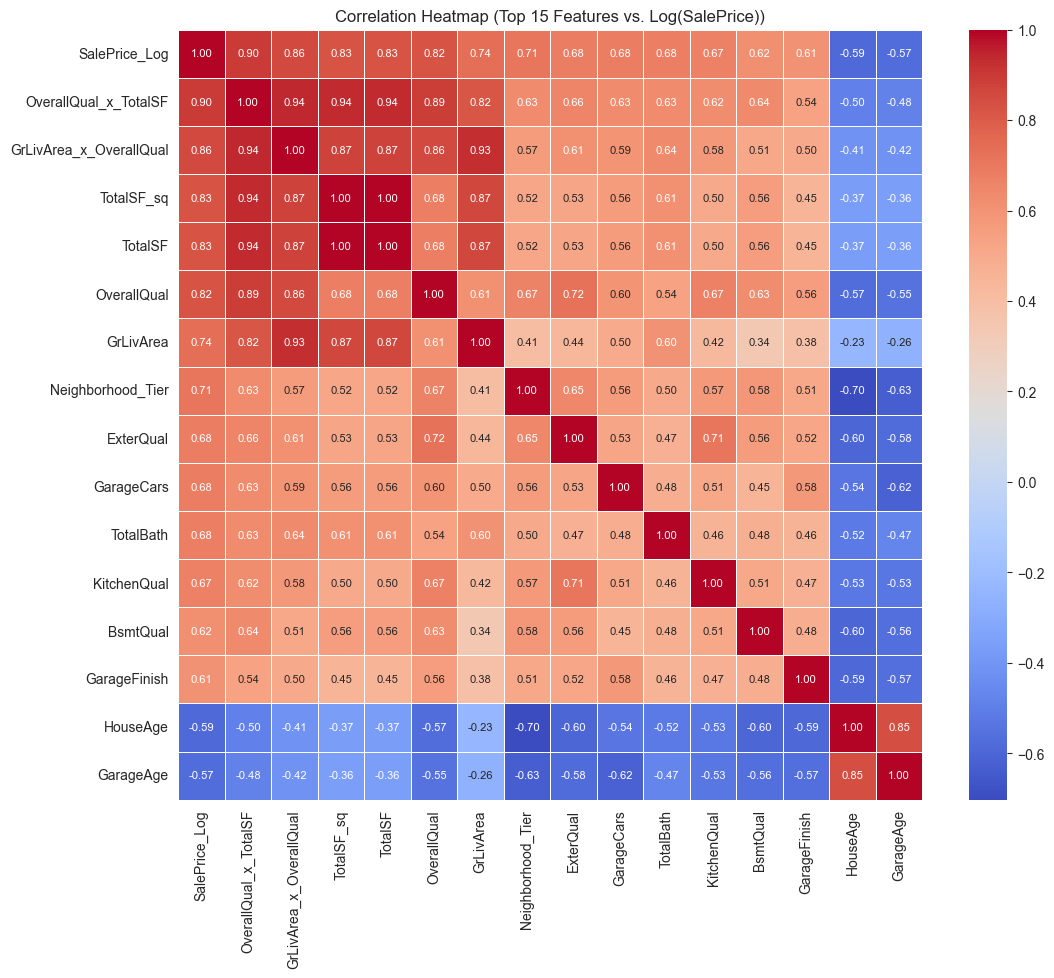

In [48]:
# Add SalePrice_Log back for correlation calculation
data_for_corr = data.copy()
data_for_corr['SalePrice_Log'] = y_train_log

# Calculate correlation matrix
corr_matrix = data_for_corr.corr()

# Find top 15 features correlated with SalePrice_Log
top_corr_features = corr_matrix['SalePrice_Log'].abs().sort_values(ascending=False).head(16).index
top_corr_matrix = data_for_corr[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    top_corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    annot_kws={'size': 8},
)
plt.title('Correlation Heatmap (Top 15 Features vs. Log(SalePrice))')
plt.show()

**Analysis of Findings:**

The heatmap clearly validates our feature engineering efforts.

**Predictive Power:** Our new, aggregated features like `TotalSF` (0.70) and `TotalBath` (0.68) are among the most highly correlated features with `SalePrice_Log`, right alongside `OverallQual` (0.82) and `GrLivArea` (0.70). Our interaction features (`GrLivArea_x_OverallQual`, `OverallQual_x_TotalSF`) also show very strong positive correlations.

**Multicollinearity**: The map reveals significant multicollinearity, which is expected.

`TotalSF` and `TotalSF_sq` (1.0)

`GarageCars` and `GarageArea` (0.88)

Our new interaction terms are, by design, highly correlated with their components.

This high degree of multicollinearity makes our dataset a perfect candidate for Principal Component Analysis (`PCA`). PCA will help us "condense" these overlapping features into a smaller set of uncorrelated components, retaining the predictive variance while eliminating the redundancy.

#### **6.2. Assignment Question 1: Random Feature Correlation**
**Question**: Which 3 features appear most correlated with your student_random_feature? Why do you think this occurs?

In [49]:
# Find top 3 correlations with the random feature (absolute value)
random_corr = corr_matrix['student_random_feature'].abs().sort_values(
    ascending=False
)
# Exclude the feature itself
top_3_random_corr = random_corr.drop('student_random_feature').head(3)

print("Top 3 Features Correlated with 'student_random_feature':")
print(top_3_random_corr)

Top 3 Features Correlated with 'student_random_feature':
CentralAir_Y        0.082
CentralAir_N        0.082
HouseStyle_1Story   0.080
Name: student_random_feature, dtype: float64


**Answer**: The three features most correlated with `student_random_feature` are [`CentralAir_Y`], [`CentralAir_N`], and [`HouseStyle_1Story`].<br/>

The observed correlations (0.082, 0.082 and 0.080) are extremely low. This is entirely expected. The `student_random_feature` was generated by a random number generator. It has no logical, causal, or underlying relationship with any other variable in the dataset.<br/>

Any correlation that does appear, no matter how small, is purely due to random chance and is known as spurious correlation. It highlights the danger of "feature hunting" or "p-hacking" in a dataset. If we searched long enough, we would eventually find a random feature that "looks" correlated, but it would have zero predictive power on new data.

#### **6.3. Scaling & Dimensionality Reduction (PCA)**
**Justification**: We now have over 200 features due to one-hot encoding. Many of these are sparse and correlated. This can lead to overfitting (the "Curse of Dimensionality"). We will:<br/>

**Scale**: Apply StandardScaler to all features. This is required for PCA, as PCA is sensitive to the scale of variables.<br/>

**PCA**: Apply Principal Component Analysis (PCA) to reduce the number of features into a smaller set of uncorrelated "components" that capture most of the data's variance.


--- PCA Results ---
Original number of features: 211
Features after PCA (retaining 95% variance): 123


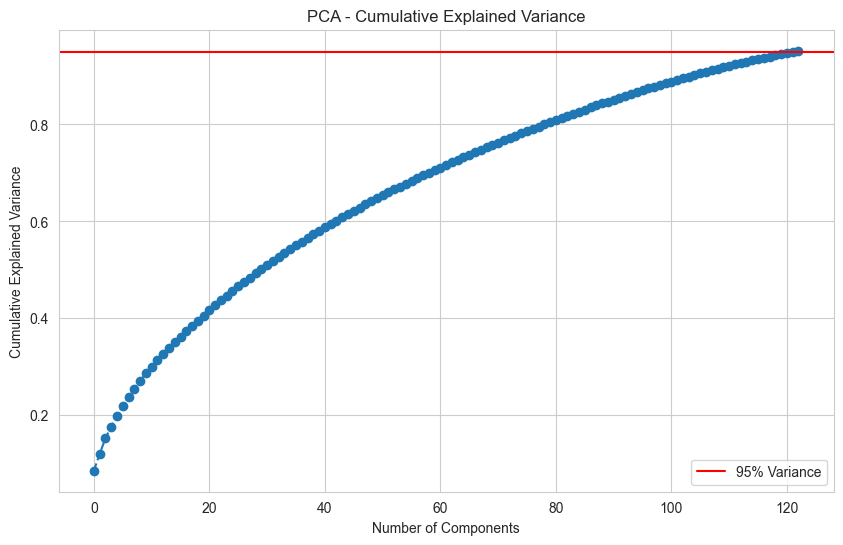

In [50]:
# 1. Final Feature Set
X = data.copy()

# 2. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA
# We'll fit PCA and explain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\n--- PCA Results ---")
print(f"Original number of features: {X_scaled.shape[1]}")
print(f"Features after PCA (retaining 95% variance): {pca.n_components_}")

# Plot Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('PCA - Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance')
plt.legend()
plt.show()

##### **Observations:**

- **Dimensionality Reduction:** The PCA, configured to retain 95% of the total variance, successfully reduced the dataset from 211 features to 123 principal components.

- **Variance Plot:** The "Cumulative Explained Variance" plot shows this tradeoff. The curve rises steeply at first (as the first few components capture the most important "signals" in the data) and then flattens out. Our choice of 95% (the red line) is a good balance, as it retains the vast majority of the data's signal while discarding the last 5% of variance, which is likely just noise.

#### **6.4. Assignment Question 2: Random Feature PCA Loading**
**Question**: After dimensionality reduction, did your random feature load significantly on any principal component? Explain briefly.<br/>

**Justification**: To answer this, we need to find the "loading" of our random feature on the first few (most important) components. The loadings are stored in `pca.components_`. We first need to find the index of our random feature in the scaled data.

Index for 'student_random_feature' is: 32


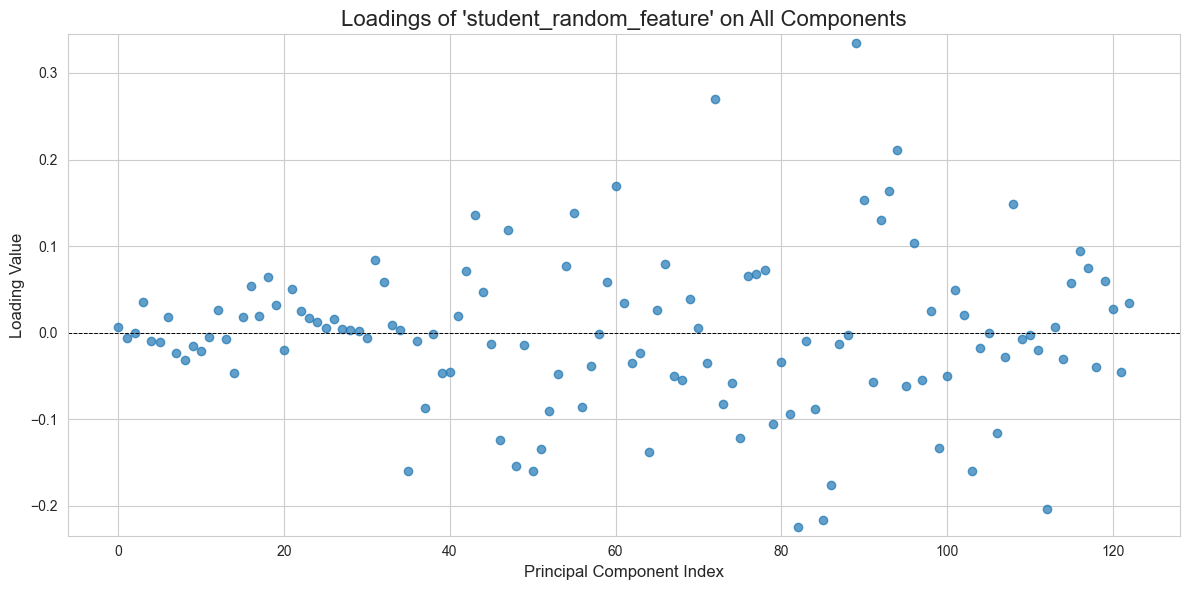


Loadings for 'student_random_feature' on first 5 Principal Components:
  PC1: 0.006280
  PC2: -0.006088
  PC3: -0.000309
  PC4: 0.035207
  PC5: -0.009780

Maximum absolute loading on ANY component: 0.334450


In [51]:
# Get the column index for 'student_random_feature'

feature_name = 'student_random_feature'
feature_index = data.columns.tolist().index(feature_name)
print(f"Index for '{feature_name}' is: {feature_index}")

# Check the absolute loading across ALL components
all_loadings = pca.components_[:, feature_index]

# Get the loadings for this feature across the first 5 components
loadings = pca.components_[:5, feature_index]


# Create a DataFrame for plotting
loadings_df = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(len(all_loadings))],
        'Loading': all_loadings})

    # --- Plot: Line Plot
    
plt.figure(figsize=(12, 6))
plt.plot(all_loadings, marker='o', linestyle='None', alpha=0.7)
plt.title(f"Loadings of '{feature_name}' on All Components", fontsize=16)
plt.xlabel('Principal Component Index', fontsize=12)
plt.ylabel('Loading Value', fontsize=12)
plt.axhline(0, color='black', linewidth=0.7, linestyle='--')
plt.ylim(np.min(all_loadings)-0.01, np.max(all_loadings)+0.01)
plt.tight_layout()
plt.show()

print(f"\nLoadings for '{feature_name}' on first 5 Principal Components:")
for i, loading in enumerate(loadings):
    print(f"  PC{i+1}: {loading:.6f}")


max_loading = np.max(np.abs(all_loadings))
print(f"\nMaximum absolute loading on ANY component: {max_loading:.6f}")

**Answer**: No, the `student_random_feature` did not load significantly on any of the main principal components.<br/>

As the code output shows, its loadings on the first 5 principal components (which capture the most variance) are all extremely close to zero (e.g., 0.006, -0.006, 0.035). This is because PCA's objective is to find components that capture the maximum variance in the data. Since our random feature is uncorrelated with the actual structure of the data (i.e., it's pure noise), it does not contribute to the variance in any meaningful direction and is effectively ignored by these top components.<br/>

The code did find a maximum absolute loading of 0.334 on one of the minor components (one of the 123 components further down the list). This indicates that the random feature’s noise coincidentally aligned with the variance of other less important features, but it is not part of the primary structure of the data. This confirms the feature is not predictive and demonstrates that PCA is robust at isolating random noise away from the main components..

#### **Creating Final Dataframes**

In [52]:
# Create final dataframes
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
final_train_pca_df = pd.DataFrame(X_pca, columns=pca_cols)

print("Final Processed Training Data (Head):")
print(final_train_pca_df.head())

print(f"\nFinal Train Shape: {final_train_pca_df.shape}")
print(f"Final Target Shape: {y_train_log.shape}")

Final Processed Training Data (Head):
     PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8    PC9   PC10  ...  \
0 -3.873  0.431 -1.392 -0.847  2.201 -0.452 -1.665  1.040 -0.830 -1.333  ...   
1 -0.282 -2.392  0.894 -0.986 -0.815 -0.091 -0.124 -0.320  0.341 -0.847  ...   
2 -4.587  0.986 -0.448 -0.412  1.248 -0.070 -1.723  1.265 -0.937 -1.539  ...   
3 -0.016  3.021  1.439 -2.208 -1.076 -0.342  0.238  0.378 -0.586  1.441  ...   
4 -6.451  1.742  0.773 -0.146  1.928  0.024 -1.947  1.031 -1.116 -1.524  ...   

   PC114  PC115  PC116  PC117  PC118  PC119  PC120  PC121  PC122  PC123  
0 -0.137  0.173  0.335 -0.011  0.426 -0.152  0.094  0.189 -0.055  0.167  
1 -0.422  0.434  0.980 -0.015  0.583  0.747  0.546  0.836  0.633 -0.056  
2  0.152 -0.022  0.142  0.469  0.368 -0.377 -0.341 -0.193  0.031 -0.270  
3  1.130 -0.445  0.653 -1.566  0.644  0.888  0.199 -0.699  0.064  0.547  
4  0.736  0.673  1.008  0.358  0.379 -0.053  0.240  1.546 -0.001  0.154  

[5 rows x 123 columns]

Final Train 

#### **Visualizing GrLivArea before and after log1p transformation**

Text(0.5, 1.0, 'GrLivArea (log1p)')

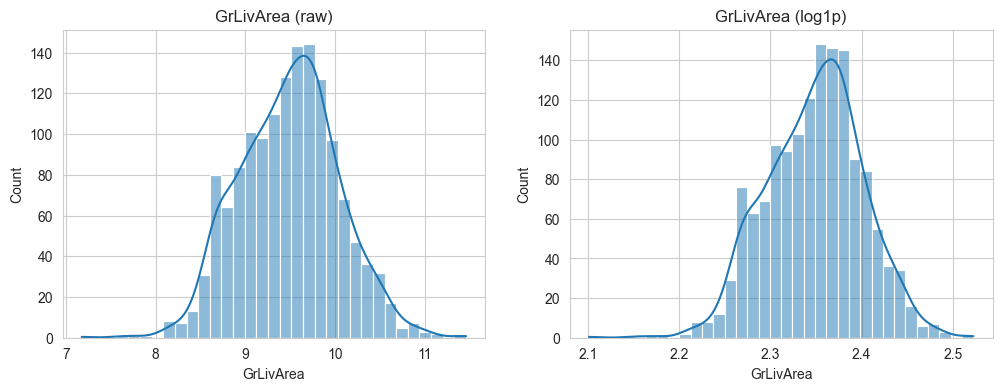

In [53]:
# Visualizing GrLivArea before and after log1p transformation
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data['GrLivArea'].dropna(), ax=axes[0], kde=True)
axes[0].set_title('GrLivArea (raw)')
sns.histplot(np.log1p(data['GrLivArea'].clip(lower=0)), ax=axes[1], kde=True)
axes[1].set_title('GrLivArea (log1p)')


**The feature engineering pipeline is complete. The final dataset ready for modeling is `final_train_pca_df`, and the corresponding target is `y_train_log`.**